In [19]:
import torch
import utils
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm

from nnsight import LanguageModel

In [20]:
k=10
n_contexts=[1,10,40,70,100,130,160,190,220,250,280,310,340,370,400]
target_count=30
batch_size=16
data_seed=123
loop_seed=56234
model_name="meta-llama/Meta-Llama-3.1-8B"
save_path="./data/markov_mixture/llama/data_8B_v3.pt"

In [21]:
llama = LanguageModel(model_name, device_map="auto")

In [12]:
comma_token_id=llama.tokenizer.encode(",")[1]
relevant_token_ids=torch.tensor([comma_token_id]+[llama.tokenizer.encode(s)[1] for s in "0123456789"],dtype=torch.int64)
relevant_token_ids

tensor([11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [13]:
Ts_collected=[]
current_Ts=torch.full((len(n_contexts),k,k),fill_value=torch.nan)
prefix="Continue the given sequence of digits between 0 and 9. The sequence comes from a Markov process, so it only depends on the last state. The sequence is as follows:\n"
token_ids_prefix=llama.tokenizer.encode(prefix)
i_sequence_start=len(token_ids_prefix)
np.random.seed(data_seed)
rss=np.random.randint(1000000,size=target_count)#this should be enough
generator=np.random.RandomState(loop_seed)
T_stars={}

i_done=0
while len(Ts_collected)<target_count:
    rs=rss[i_done]
    dataset_star=utils.get_markov_dataset_single(k=k,l=n_contexts[-1]+5,structured=False,random_state=rs)
    T_stars[i_done]=torch.tensor(dataset_star.T)
    np.random.seed(generator.randint(1000000))#generator set outside so each loop is different
    seqs=[]
    positions=[]
    token_ids=[]
    for _ in range(batch_size):
        seq=dataset_star.get_data()
        seqs.append(seq)
        data_str=",".join(seq.numpy().astype(str))
        data_str=prefix+data_str
        token_ids_=llama.tokenizer.encode(data_str,return_tensors="pt")
        token_ids.append(token_ids_)
    seqs=torch.stack(seqs,dim=0)
    print("Seqs shape:",seqs.shape)
    token_ids=torch.cat(token_ids,dim=0)
    print("Token ids shape:",token_ids.shape)
    
    with llama.trace(token_ids, remote=True) as runner:
        logits=llama.output.logits
        relevant_logits=logits[:,:,relevant_token_ids].save()
    print("Relevant logits shape:",relevant_logits.shape)
    
    positions=np.arange(i_sequence_start+1,token_ids.shape[1],2).tolist()#comma positions
    relevant_logits=relevant_logits[:,positions,:]
    comma_probs=torch.nn.functional.softmax(relevant_logits,dim=-1)[:,:,0]
    if torch.any(comma_probs>1e-2):
        print("Found a comma, skipping")
        continue
    probss=torch.nn.functional.softmax(relevant_logits[:,:,1:],dim=-1)
    print("Probss shape:",probss.shape)
        
    for i_n_context,n_context in enumerate(n_contexts):
        for seq,probs in zip(seqs,probss):
            last_state=seq[n_context-1]
            val=current_Ts[i_n_context,last_state,:]
            if torch.isnan(val[0]):
                current_Ts[i_n_context,last_state,:]=probs[n_context-1,:]
    #check if Ts are filled
    if torch.all(~torch.isnan(current_Ts)):
        print("Ts are filled, collecting")
        Ts_collected.append(current_Ts.clone())
        current_Ts[...]=torch.nan
        i_done+=1
    print(f"Collected {len(Ts_collected)} Tss")
Ts_collected=torch.stack(Ts_collected)
T_stars=torch.stack([T_stars[i] for i in range(target_count)],dim=0)
Ts_collected.shape,T_stars.shape

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:53:32,601 MainProcess nnsight_remote INFO     c5a6f5f1-baef-4d1c-96f6-a5263106b663 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:53:32,644 MainProcess nnsight_remote INFO     c5a6f5f1-baef-4d1c-96f6-a5263106b663 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:34,015 MainProcess nnsight_remote INFO     c5a6f5f1-baef-4d1c-96f6-a5263106b663 - RUNNING: Your job has started running.
2024-09-14 15:55:35,878 MainProcess nnsight_remote INFO     c5a6f5f1-baef-4d1c-96f6-a5263106b663 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:37,318 MainProcess nnsight_remote INFO     5bf05b59-6950-49dd-9f91-30d033ce5eed - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:37,369 MainProcess nnsight_remote INFO     5bf05b59-6950-49dd-9f91-30d033ce5eed - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:37,449 MainProcess nnsight_remote INFO     5bf05b59-6950-49dd-9f91-30d033ce5eed - RUNNING: Your job has started running.
2024-09-14 15:55:39,191 MainProcess nnsight_remote INFO     5bf05b59-6950-49dd-9f91-30d033ce5eed - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:40,653 MainProcess nnsight_remote INFO     4a3efb49-1a3c-4430-bc1c-f5a12a5a1d12 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:40,695 MainProcess nnsight_remote INFO     4a3efb49-1a3c-4430-bc1c-f5a12a5a1d12 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:40,715 MainProcess nnsight_remote INFO     4a3efb49-1a3c-4430-bc1c-f5a12a5a1d12 - RUNNING: Your job has started running.
2024-09-14 15:55:42,512 MainProcess nnsight_remote INFO     4a3efb49-1a3c-4430-bc1c-f5a12a5a1d12 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:43,790 MainProcess nnsight_remote INFO     cd343962-dc0e-40d4-acd7-6b723f57aa3d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:43,841 MainProcess nnsight_remote INFO     cd343962-dc0e-40d4-acd7-6b723f57aa3d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:43,863 MainProcess nnsight_remote INFO     cd343962-dc0e-40d4-acd7-6b723f57aa3d - RUNNING: Your job has started running.
2024-09-14 15:55:45,618 MainProcess nnsight_remote INFO     cd343962-dc0e-40d4-acd7-6b723f57aa3d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:47,302 MainProcess nnsight_remote INFO     0b8409e9-76b2-4d28-82fd-cf960b115788 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:47,341 MainProcess nnsight_remote INFO     0b8409e9-76b2-4d28-82fd-cf960b115788 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:47,366 MainProcess nnsight_remote INFO     0b8409e9-76b2-4d28-82fd-cf960b115788 - RUNNING: Your job has started running.
2024-09-14 15:55:49,141 MainProcess nnsight_remote INFO     0b8409e9-76b2-4d28-82fd-cf960b115788 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:50,265 MainProcess nnsight_remote INFO     8a38cef8-aac7-4617-a3fa-cf0a328db39f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:50,571 MainProcess nnsight_remote INFO     8a38cef8-aac7-4617-a3fa-cf0a328db39f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:50,590 MainProcess nnsight_remote INFO     8a38cef8-aac7-4617-a3fa-cf0a328db39f - RUNNING: Your job has started running.
2024-09-14 15:55:52,363 MainProcess nnsight_remote INFO     8a38cef8-aac7-4617-a3fa-cf0a328db39f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:53,589 MainProcess nnsight_remote INFO     bea53f79-5f84-4a3b-8281-5b6af6df7a56 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:53,630 MainProcess nnsight_remote INFO     bea53f79-5f84-4a3b-8281-5b6af6df7a56 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:53,668 MainProcess nnsight_remote INFO     bea53f79-5f84-4a3b-8281-5b6af6df7a56 - RUNNING: Your job has started running.
2024-09-14 15:55:55,447 MainProcess nnsight_remote INFO     bea53f79-5f84-4a3b-8281-5b6af6df7a56 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:56,664 MainProcess nnsight_remote INFO     607c2fb9-14ef-4cc2-8b0c-0778eaa27a8d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:56,690 MainProcess nnsight_remote INFO     607c2fb9-14ef-4cc2-8b0c-0778eaa27a8d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:55:56,714 MainProcess nnsight_remote INFO     607c2fb9-14ef-4cc2-8b0c-0778eaa27a8d - RUNNING: Your job has started running.
2024-09-14 15:55:58,520 MainProcess nnsight_remote INFO     607c2fb9-14ef-4cc2-8b0c-0778eaa27a8d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:55:59,920 MainProcess nnsight_remote INFO     679ec6f9-312a-4af1-b40a-d6a149abfc7a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:55:59,958 MainProcess nnsight_remote INFO     679ec6f9-312a-4af1-b40a-d6a149abfc7a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:00,002 MainProcess nnsight_remote INFO     679ec6f9-312a-4af1-b40a-d6a149abfc7a - RUNNING: Your job has started running.
2024-09-14 15:56:01,791 MainProcess nnsight_remote INFO     679ec6f9-312a-4af1-b40a-d6a149abfc7a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:03,121 MainProcess nnsight_remote INFO     eed76eeb-f68e-4f0a-ae93-d158c9b23f49 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:03,161 MainProcess nnsight_remote INFO     eed76eeb-f68e-4f0a-ae93-d158c9b23f49 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:03,235 MainProcess nnsight_remote INFO     eed76eeb-f68e-4f0a-ae93-d158c9b23f49 - RUNNING: Your job has started running.
2024-09-14 15:56:05,072 MainProcess nnsight_remote INFO     eed76eeb-f68e-4f0a-ae93-d158c9b23f49 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:06,411 MainProcess nnsight_remote INFO     08b1aa81-95e3-46e9-8f80-47e832f8aa3e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:06,445 MainProcess nnsight_remote INFO     08b1aa81-95e3-46e9-8f80-47e832f8aa3e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:06,477 MainProcess nnsight_remote INFO     08b1aa81-95e3-46e9-8f80-47e832f8aa3e - RUNNING: Your job has started running.
2024-09-14 15:56:08,319 MainProcess nnsight_remote INFO     08b1aa81-95e3-46e9-8f80-47e832f8aa3e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:09,539 MainProcess nnsight_remote INFO     600c67dc-f872-4434-a6b9-a583218a5f87 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:09,590 MainProcess nnsight_remote INFO     600c67dc-f872-4434-a6b9-a583218a5f87 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:09,616 MainProcess nnsight_remote INFO     600c67dc-f872-4434-a6b9-a583218a5f87 - RUNNING: Your job has started running.
2024-09-14 15:56:11,443 MainProcess nnsight_remote INFO     600c67dc-f872-4434-a6b9-a583218a5f87 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:12,634 MainProcess nnsight_remote INFO     95c29e86-8b67-4845-b25b-d10bd4c19a0d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:12,673 MainProcess nnsight_remote INFO     95c29e86-8b67-4845-b25b-d10bd4c19a0d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:12,726 MainProcess nnsight_remote INFO     95c29e86-8b67-4845-b25b-d10bd4c19a0d - RUNNING: Your job has started running.
2024-09-14 15:56:14,568 MainProcess nnsight_remote INFO     95c29e86-8b67-4845-b25b-d10bd4c19a0d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:15,962 MainProcess nnsight_remote INFO     27c617fb-3757-4e98-87e9-ea467ee257f6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:16,039 MainProcess nnsight_remote INFO     27c617fb-3757-4e98-87e9-ea467ee257f6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:16,074 MainProcess nnsight_remote INFO     27c617fb-3757-4e98-87e9-ea467ee257f6 - RUNNING: Your job has started running.
2024-09-14 15:56:17,929 MainProcess nnsight_remote INFO     27c617fb-3757-4e98-87e9-ea467ee257f6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:19,062 MainProcess nnsight_remote INFO     c5d31b16-12fb-4a65-b4de-01a67b906f59 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:19,103 MainProcess nnsight_remote INFO     c5d31b16-12fb-4a65-b4de-01a67b906f59 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:19,138 MainProcess nnsight_remote INFO     c5d31b16-12fb-4a65-b4de-01a67b906f59 - RUNNING: Your job has started running.
2024-09-14 15:56:21,007 MainProcess nnsight_remote INFO     c5d31b16-12fb-4a65-b4de-01a67b906f59 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:22,345 MainProcess nnsight_remote INFO     7ebc0507-6c50-4f98-8274-135a9b84a478 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:22,418 MainProcess nnsight_remote INFO     7ebc0507-6c50-4f98-8274-135a9b84a478 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:22,490 MainProcess nnsight_remote INFO     7ebc0507-6c50-4f98-8274-135a9b84a478 - RUNNING: Your job has started running.
2024-09-14 15:56:24,365 MainProcess nnsight_remote INFO     7ebc0507-6c50-4f98-8274-135a9b84a478 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:25,726 MainProcess nnsight_remote INFO     e2930d43-76f5-4ee1-8979-9b1e408d74dd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:25,759 MainProcess nnsight_remote INFO     e2930d43-76f5-4ee1-8979-9b1e408d74dd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:25,814 MainProcess nnsight_remote INFO     e2930d43-76f5-4ee1-8979-9b1e408d74dd - RUNNING: Your job has started running.
2024-09-14 15:56:27,718 MainProcess nnsight_remote INFO     e2930d43-76f5-4ee1-8979-9b1e408d74dd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:28,968 MainProcess nnsight_remote INFO     63ae9310-8829-4e61-8604-985a437c9755 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:29,006 MainProcess nnsight_remote INFO     63ae9310-8829-4e61-8604-985a437c9755 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:29,041 MainProcess nnsight_remote INFO     63ae9310-8829-4e61-8604-985a437c9755 - RUNNING: Your job has started running.
2024-09-14 15:56:30,987 MainProcess nnsight_remote INFO     63ae9310-8829-4e61-8604-985a437c9755 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:32,225 MainProcess nnsight_remote INFO     26b477df-75cf-48c4-a841-ee63ae250021 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:32,266 MainProcess nnsight_remote INFO     26b477df-75cf-48c4-a841-ee63ae250021 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:32,292 MainProcess nnsight_remote INFO     26b477df-75cf-48c4-a841-ee63ae250021 - RUNNING: Your job has started running.
2024-09-14 15:56:34,168 MainProcess nnsight_remote INFO     26b477df-75cf-48c4-a841-ee63ae250021 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:35,250 MainProcess nnsight_remote INFO     16fef62c-9826-4823-b22c-0459030274ab - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:35,303 MainProcess nnsight_remote INFO     16fef62c-9826-4823-b22c-0459030274ab - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:35,325 MainProcess nnsight_remote INFO     16fef62c-9826-4823-b22c-0459030274ab - RUNNING: Your job has started running.
2024-09-14 15:56:37,182 MainProcess nnsight_remote INFO     16fef62c-9826-4823-b22c-0459030274ab - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:38,568 MainProcess nnsight_remote INFO     cba361f4-8985-4bec-a73e-068e5cb4fd8e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:38,626 MainProcess nnsight_remote INFO     cba361f4-8985-4bec-a73e-068e5cb4fd8e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:56:38,768 MainProcess nnsight_remote INFO     cba361f4-8985-4bec-a73e-068e5cb4fd8e - RUNNING: Your job has started running.
2024-09-14 15:56:40,717 MainProcess nnsight_remote INFO     cba361f4-8985-4bec-a73e-068e5cb4fd8e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:56:41,998 MainProcess nnsight_remote INFO     77016bff-f4a5-4fb0-afe7-4cc54d043e09 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:56:42,032 MainProcess nnsight_remote INFO     77016bff-f4a5-4fb0-afe7-4cc54d043e09 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:08,937 MainProcess nnsight_remote INFO     77016bff-f4a5-4fb0-afe7-4cc54d043e09 - RUNNING: Your job has started running.
2024-09-14 15:57:10,413 MainProcess nnsight_remote INFO     77016bff-f4a5-4fb0-afe7-4cc54d043e09 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:11,831 MainProcess nnsight_remote INFO     788998a2-52de-47f7-bea5-11af68d1a5cd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:11,869 MainProcess nnsight_remote INFO     788998a2-52de-47f7-bea5-11af68d1a5cd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:11,899 MainProcess nnsight_remote INFO     788998a2-52de-47f7-bea5-11af68d1a5cd - RUNNING: Your job has started running.
2024-09-14 15:57:13,802 MainProcess nnsight_remote INFO     788998a2-52de-47f7-bea5-11af68d1a5cd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:15,146 MainProcess nnsight_remote INFO     4693e19a-0c07-426a-8102-63ecf85fa4a8 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:15,178 MainProcess nnsight_remote INFO     4693e19a-0c07-426a-8102-63ecf85fa4a8 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:15,210 MainProcess nnsight_remote INFO     4693e19a-0c07-426a-8102-63ecf85fa4a8 - RUNNING: Your job has started running.
2024-09-14 15:57:17,145 MainProcess nnsight_remote INFO     4693e19a-0c07-426a-8102-63ecf85fa4a8 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:18,720 MainProcess nnsight_remote INFO     831775ca-babc-4b51-95e9-979fd3b7f608 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:18,743 MainProcess nnsight_remote INFO     831775ca-babc-4b51-95e9-979fd3b7f608 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:18,794 MainProcess nnsight_remote INFO     831775ca-babc-4b51-95e9-979fd3b7f608 - RUNNING: Your job has started running.
2024-09-14 15:57:20,989 MainProcess nnsight_remote INFO     831775ca-babc-4b51-95e9-979fd3b7f608 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:22,280 MainProcess nnsight_remote INFO     9c9b9cc5-5103-43d0-8f0b-a81a6c46368e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:22,337 MainProcess nnsight_remote INFO     9c9b9cc5-5103-43d0-8f0b-a81a6c46368e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:22,383 MainProcess nnsight_remote INFO     9c9b9cc5-5103-43d0-8f0b-a81a6c46368e - RUNNING: Your job has started running.
2024-09-14 15:57:24,366 MainProcess nnsight_remote INFO     9c9b9cc5-5103-43d0-8f0b-a81a6c46368e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:25,890 MainProcess nnsight_remote INFO     198912bf-67e2-4e09-b42e-7b230c7409a4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:25,931 MainProcess nnsight_remote INFO     198912bf-67e2-4e09-b42e-7b230c7409a4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:25,948 MainProcess nnsight_remote INFO     198912bf-67e2-4e09-b42e-7b230c7409a4 - RUNNING: Your job has started running.
2024-09-14 15:57:28,070 MainProcess nnsight_remote INFO     198912bf-67e2-4e09-b42e-7b230c7409a4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:29,469 MainProcess nnsight_remote INFO     81401c3e-3186-4b5c-b506-c7c09f598168 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:29,527 MainProcess nnsight_remote INFO     81401c3e-3186-4b5c-b506-c7c09f598168 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:29,594 MainProcess nnsight_remote INFO     81401c3e-3186-4b5c-b506-c7c09f598168 - RUNNING: Your job has started running.
2024-09-14 15:57:31,557 MainProcess nnsight_remote INFO     81401c3e-3186-4b5c-b506-c7c09f598168 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:32,868 MainProcess nnsight_remote INFO     bbf70583-3b0a-4814-8abb-aa68a19dad76 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:32,912 MainProcess nnsight_remote INFO     bbf70583-3b0a-4814-8abb-aa68a19dad76 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:32,944 MainProcess nnsight_remote INFO     bbf70583-3b0a-4814-8abb-aa68a19dad76 - RUNNING: Your job has started running.
2024-09-14 15:57:34,919 MainProcess nnsight_remote INFO     bbf70583-3b0a-4814-8abb-aa68a19dad76 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:36,129 MainProcess nnsight_remote INFO     59552e17-05d8-43df-b5c2-a85cbd196790 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:36,174 MainProcess nnsight_remote INFO     59552e17-05d8-43df-b5c2-a85cbd196790 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:36,212 MainProcess nnsight_remote INFO     59552e17-05d8-43df-b5c2-a85cbd196790 - RUNNING: Your job has started running.
2024-09-14 15:57:38,176 MainProcess nnsight_remote INFO     59552e17-05d8-43df-b5c2-a85cbd196790 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:39,625 MainProcess nnsight_remote INFO     a1177bcf-07c6-436d-a010-ad7c74ff2dde - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:39,672 MainProcess nnsight_remote INFO     a1177bcf-07c6-436d-a010-ad7c74ff2dde - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:39,729 MainProcess nnsight_remote INFO     a1177bcf-07c6-436d-a010-ad7c74ff2dde - RUNNING: Your job has started running.
2024-09-14 15:57:41,694 MainProcess nnsight_remote INFO     a1177bcf-07c6-436d-a010-ad7c74ff2dde - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:43,278 MainProcess nnsight_remote INFO     b8cbd4c6-908a-41df-ae4a-d5e70453739f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:43,308 MainProcess nnsight_remote INFO     b8cbd4c6-908a-41df-ae4a-d5e70453739f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:43,358 MainProcess nnsight_remote INFO     b8cbd4c6-908a-41df-ae4a-d5e70453739f - RUNNING: Your job has started running.
2024-09-14 15:57:45,503 MainProcess nnsight_remote INFO     b8cbd4c6-908a-41df-ae4a-d5e70453739f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:46,783 MainProcess nnsight_remote INFO     01d0cee7-1d15-4bf6-a58c-2e4a7bd647be - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:46,822 MainProcess nnsight_remote INFO     01d0cee7-1d15-4bf6-a58c-2e4a7bd647be - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:46,850 MainProcess nnsight_remote INFO     01d0cee7-1d15-4bf6-a58c-2e4a7bd647be - RUNNING: Your job has started running.
2024-09-14 15:57:48,832 MainProcess nnsight_remote INFO     01d0cee7-1d15-4bf6-a58c-2e4a7bd647be - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:50,203 MainProcess nnsight_remote INFO     796b1910-b1d2-4f6d-9e1f-a9c46319e58d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:50,233 MainProcess nnsight_remote INFO     796b1910-b1d2-4f6d-9e1f-a9c46319e58d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:51,067 MainProcess nnsight_remote INFO     796b1910-b1d2-4f6d-9e1f-a9c46319e58d - RUNNING: Your job has started running.
2024-09-14 15:57:52,278 MainProcess nnsight_remote INFO     796b1910-b1d2-4f6d-9e1f-a9c46319e58d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:53,346 MainProcess nnsight_remote INFO     28061734-b4ab-4227-945a-608c90c9149b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:53,377 MainProcess nnsight_remote INFO     28061734-b4ab-4227-945a-608c90c9149b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:53,457 MainProcess nnsight_remote INFO     28061734-b4ab-4227-945a-608c90c9149b - RUNNING: Your job has started running.
2024-09-14 15:57:55,441 MainProcess nnsight_remote INFO     28061734-b4ab-4227-945a-608c90c9149b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:57:56,777 MainProcess nnsight_remote INFO     5bafa772-15eb-4c63-bb8e-a58ed062a353 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:57:56,835 MainProcess nnsight_remote INFO     5bafa772-15eb-4c63-bb8e-a58ed062a353 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:57:56,867 MainProcess nnsight_remote INFO     5bafa772-15eb-4c63-bb8e-a58ed062a353 - RUNNING: Your job has started running.
2024-09-14 15:57:58,811 MainProcess nnsight_remote INFO     5bafa772-15eb-4c63-bb8e-a58ed062a353 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:00,088 MainProcess nnsight_remote INFO     f24cc638-db12-4d73-bdbb-9da6bde2ed96 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:00,116 MainProcess nnsight_remote INFO     f24cc638-db12-4d73-bdbb-9da6bde2ed96 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:00,144 MainProcess nnsight_remote INFO     f24cc638-db12-4d73-bdbb-9da6bde2ed96 - RUNNING: Your job has started running.
2024-09-14 15:58:02,145 MainProcess nnsight_remote INFO     f24cc638-db12-4d73-bdbb-9da6bde2ed96 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:03,552 MainProcess nnsight_remote INFO     9264f981-558d-4eaa-b1f7-af2e63bc41c7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:03,626 MainProcess nnsight_remote INFO     9264f981-558d-4eaa-b1f7-af2e63bc41c7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:03,656 MainProcess nnsight_remote INFO     9264f981-558d-4eaa-b1f7-af2e63bc41c7 - RUNNING: Your job has started running.
2024-09-14 15:58:05,645 MainProcess nnsight_remote INFO     9264f981-558d-4eaa-b1f7-af2e63bc41c7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:07,003 MainProcess nnsight_remote INFO     90c93a5a-42c9-403c-9434-954c004c58e7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:07,035 MainProcess nnsight_remote INFO     90c93a5a-42c9-403c-9434-954c004c58e7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:07,051 MainProcess nnsight_remote INFO     90c93a5a-42c9-403c-9434-954c004c58e7 - RUNNING: Your job has started running.
2024-09-14 15:58:09,075 MainProcess nnsight_remote INFO     90c93a5a-42c9-403c-9434-954c004c58e7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:10,380 MainProcess nnsight_remote INFO     096f4c88-0539-4b94-ac7d-4d5b78d394fd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:10,453 MainProcess nnsight_remote INFO     096f4c88-0539-4b94-ac7d-4d5b78d394fd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:10,468 MainProcess nnsight_remote INFO     096f4c88-0539-4b94-ac7d-4d5b78d394fd - RUNNING: Your job has started running.
2024-09-14 15:58:12,438 MainProcess nnsight_remote INFO     096f4c88-0539-4b94-ac7d-4d5b78d394fd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:13,561 MainProcess nnsight_remote INFO     385c83eb-d23a-4d1b-a357-d57e536ed56f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:13,601 MainProcess nnsight_remote INFO     385c83eb-d23a-4d1b-a357-d57e536ed56f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:13,623 MainProcess nnsight_remote INFO     385c83eb-d23a-4d1b-a357-d57e536ed56f - RUNNING: Your job has started running.
2024-09-14 15:58:15,945 MainProcess nnsight_remote INFO     385c83eb-d23a-4d1b-a357-d57e536ed56f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:17,164 MainProcess nnsight_remote INFO     ceab21b3-1f22-47b7-b514-f519d04c77c5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:17,201 MainProcess nnsight_remote INFO     ceab21b3-1f22-47b7-b514-f519d04c77c5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:17,228 MainProcess nnsight_remote INFO     ceab21b3-1f22-47b7-b514-f519d04c77c5 - RUNNING: Your job has started running.
2024-09-14 15:58:19,167 MainProcess nnsight_remote INFO     ceab21b3-1f22-47b7-b514-f519d04c77c5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:20,425 MainProcess nnsight_remote INFO     338c6b83-38c0-4d52-90f5-de4a7bc05775 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:20,482 MainProcess nnsight_remote INFO     338c6b83-38c0-4d52-90f5-de4a7bc05775 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:20,510 MainProcess nnsight_remote INFO     338c6b83-38c0-4d52-90f5-de4a7bc05775 - RUNNING: Your job has started running.
2024-09-14 15:58:22,470 MainProcess nnsight_remote INFO     338c6b83-38c0-4d52-90f5-de4a7bc05775 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:23,790 MainProcess nnsight_remote INFO     00019352-b7c4-40e8-ada8-aed1d30a9592 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:23,854 MainProcess nnsight_remote INFO     00019352-b7c4-40e8-ada8-aed1d30a9592 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:23,882 MainProcess nnsight_remote INFO     00019352-b7c4-40e8-ada8-aed1d30a9592 - RUNNING: Your job has started running.
2024-09-14 15:58:25,840 MainProcess nnsight_remote INFO     00019352-b7c4-40e8-ada8-aed1d30a9592 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:27,182 MainProcess nnsight_remote INFO     cb16d418-0e8a-4689-8cea-6197da3834ea - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:27,224 MainProcess nnsight_remote INFO     cb16d418-0e8a-4689-8cea-6197da3834ea - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:27,253 MainProcess nnsight_remote INFO     cb16d418-0e8a-4689-8cea-6197da3834ea - RUNNING: Your job has started running.
2024-09-14 15:58:29,425 MainProcess nnsight_remote INFO     cb16d418-0e8a-4689-8cea-6197da3834ea - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:30,760 MainProcess nnsight_remote INFO     700d1db2-b0bd-4d6a-be15-0dd9ebd43725 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:30,813 MainProcess nnsight_remote INFO     700d1db2-b0bd-4d6a-be15-0dd9ebd43725 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:30,846 MainProcess nnsight_remote INFO     700d1db2-b0bd-4d6a-be15-0dd9ebd43725 - RUNNING: Your job has started running.
2024-09-14 15:58:33,201 MainProcess nnsight_remote INFO     700d1db2-b0bd-4d6a-be15-0dd9ebd43725 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:34,562 MainProcess nnsight_remote INFO     5f03e157-4f25-4ee5-9bf1-c79121726a51 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:34,612 MainProcess nnsight_remote INFO     5f03e157-4f25-4ee5-9bf1-c79121726a51 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:34,640 MainProcess nnsight_remote INFO     5f03e157-4f25-4ee5-9bf1-c79121726a51 - RUNNING: Your job has started running.
2024-09-14 15:58:36,589 MainProcess nnsight_remote INFO     5f03e157-4f25-4ee5-9bf1-c79121726a51 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:37,793 MainProcess nnsight_remote INFO     7040bb3f-162b-47bc-978b-78f85994fe15 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:37,830 MainProcess nnsight_remote INFO     7040bb3f-162b-47bc-978b-78f85994fe15 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:37,899 MainProcess nnsight_remote INFO     7040bb3f-162b-47bc-978b-78f85994fe15 - RUNNING: Your job has started running.
2024-09-14 15:58:39,874 MainProcess nnsight_remote INFO     7040bb3f-162b-47bc-978b-78f85994fe15 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:41,234 MainProcess nnsight_remote INFO     cb9242ce-f32d-422d-9ec0-9a90079f1151 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:41,291 MainProcess nnsight_remote INFO     cb9242ce-f32d-422d-9ec0-9a90079f1151 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:41,389 MainProcess nnsight_remote INFO     cb9242ce-f32d-422d-9ec0-9a90079f1151 - RUNNING: Your job has started running.
2024-09-14 15:58:43,391 MainProcess nnsight_remote INFO     cb9242ce-f32d-422d-9ec0-9a90079f1151 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:45,285 MainProcess nnsight_remote INFO     44a3f312-20e2-404a-937d-850b17cd5945 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:45,352 MainProcess nnsight_remote INFO     44a3f312-20e2-404a-937d-850b17cd5945 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:45,392 MainProcess nnsight_remote INFO     44a3f312-20e2-404a-937d-850b17cd5945 - RUNNING: Your job has started running.
2024-09-14 15:58:47,360 MainProcess nnsight_remote INFO     44a3f312-20e2-404a-937d-850b17cd5945 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:48,682 MainProcess nnsight_remote INFO     0024b628-532a-4076-a915-23dc6e5fdb42 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:48,730 MainProcess nnsight_remote INFO     0024b628-532a-4076-a915-23dc6e5fdb42 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:48,754 MainProcess nnsight_remote INFO     0024b628-532a-4076-a915-23dc6e5fdb42 - RUNNING: Your job has started running.
2024-09-14 15:58:50,707 MainProcess nnsight_remote INFO     0024b628-532a-4076-a915-23dc6e5fdb42 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:52,064 MainProcess nnsight_remote INFO     ea60511d-1aab-42c5-aa29-d09f0c48c999 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:52,087 MainProcess nnsight_remote INFO     ea60511d-1aab-42c5-aa29-d09f0c48c999 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:52,116 MainProcess nnsight_remote INFO     ea60511d-1aab-42c5-aa29-d09f0c48c999 - RUNNING: Your job has started running.
2024-09-14 15:58:54,105 MainProcess nnsight_remote INFO     ea60511d-1aab-42c5-aa29-d09f0c48c999 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:55,527 MainProcess nnsight_remote INFO     94842983-92d5-486a-99c7-2e0e0854318f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:55,590 MainProcess nnsight_remote INFO     94842983-92d5-486a-99c7-2e0e0854318f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:55,620 MainProcess nnsight_remote INFO     94842983-92d5-486a-99c7-2e0e0854318f - RUNNING: Your job has started running.
2024-09-14 15:58:57,567 MainProcess nnsight_remote INFO     94842983-92d5-486a-99c7-2e0e0854318f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:58:59,036 MainProcess nnsight_remote INFO     bf0feaf0-cd6d-40cb-af8d-d3d03048c078 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:59,110 MainProcess nnsight_remote INFO     bf0feaf0-cd6d-40cb-af8d-d3d03048c078 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:59,157 MainProcess nnsight_remote INFO     bf0feaf0-cd6d-40cb-af8d-d3d03048c078 - RUNNING: Your job has started running.
2024-09-14 15:59:01,107 MainProcess nnsight_remote INFO     bf0feaf0-cd6d-40cb-af8d-d3d03048c078 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:02,401 MainProcess nnsight_remote INFO     82a5af45-2d1f-4c56-903c-33d9ba9cdeb0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:02,428 MainProcess nnsight_remote INFO     82a5af45-2d1f-4c56-903c-33d9ba9cdeb0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:02,452 MainProcess nnsight_remote INFO     82a5af45-2d1f-4c56-903c-33d9ba9cdeb0 - RUNNING: Your job has started running.
2024-09-14 15:59:04,466 MainProcess nnsight_remote INFO     82a5af45-2d1f-4c56-903c-33d9ba9cdeb0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:05,710 MainProcess nnsight_remote INFO     339069db-d7f5-4c0e-8133-1de9304c9604 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:05,850 MainProcess nnsight_remote INFO     339069db-d7f5-4c0e-8133-1de9304c9604 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:05,866 MainProcess nnsight_remote INFO     339069db-d7f5-4c0e-8133-1de9304c9604 - RUNNING: Your job has started running.
2024-09-14 15:59:07,828 MainProcess nnsight_remote INFO     339069db-d7f5-4c0e-8133-1de9304c9604 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:09,176 MainProcess nnsight_remote INFO     2b4b786a-6912-4171-a249-e49b4996aa36 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:09,231 MainProcess nnsight_remote INFO     2b4b786a-6912-4171-a249-e49b4996aa36 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:09,260 MainProcess nnsight_remote INFO     2b4b786a-6912-4171-a249-e49b4996aa36 - RUNNING: Your job has started running.
2024-09-14 15:59:11,221 MainProcess nnsight_remote INFO     2b4b786a-6912-4171-a249-e49b4996aa36 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:12,646 MainProcess nnsight_remote INFO     e89357eb-0643-4612-acec-95125cbcc34b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:12,679 MainProcess nnsight_remote INFO     e89357eb-0643-4612-acec-95125cbcc34b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:12,696 MainProcess nnsight_remote INFO     e89357eb-0643-4612-acec-95125cbcc34b - RUNNING: Your job has started running.
2024-09-14 15:59:14,664 MainProcess nnsight_remote INFO     e89357eb-0643-4612-acec-95125cbcc34b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:15,946 MainProcess nnsight_remote INFO     91d096ae-a7e5-4ae8-8277-1b7a8d56a34e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:15,995 MainProcess nnsight_remote INFO     91d096ae-a7e5-4ae8-8277-1b7a8d56a34e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:16,014 MainProcess nnsight_remote INFO     91d096ae-a7e5-4ae8-8277-1b7a8d56a34e - RUNNING: Your job has started running.
2024-09-14 15:59:17,966 MainProcess nnsight_remote INFO     91d096ae-a7e5-4ae8-8277-1b7a8d56a34e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:19,302 MainProcess nnsight_remote INFO     509d2a24-5f43-4b52-b414-7fa307c93f2f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:19,347 MainProcess nnsight_remote INFO     509d2a24-5f43-4b52-b414-7fa307c93f2f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:19,383 MainProcess nnsight_remote INFO     509d2a24-5f43-4b52-b414-7fa307c93f2f - RUNNING: Your job has started running.
2024-09-14 15:59:21,466 MainProcess nnsight_remote INFO     509d2a24-5f43-4b52-b414-7fa307c93f2f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:22,807 MainProcess nnsight_remote INFO     78742cdd-2fee-44ad-bac4-a676ed256cfb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:22,829 MainProcess nnsight_remote INFO     78742cdd-2fee-44ad-bac4-a676ed256cfb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:22,845 MainProcess nnsight_remote INFO     78742cdd-2fee-44ad-bac4-a676ed256cfb - RUNNING: Your job has started running.
2024-09-14 15:59:24,811 MainProcess nnsight_remote INFO     78742cdd-2fee-44ad-bac4-a676ed256cfb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:25,943 MainProcess nnsight_remote INFO     8aac4c88-e9bc-40e1-9d25-ecc66de01c67 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:25,971 MainProcess nnsight_remote INFO     8aac4c88-e9bc-40e1-9d25-ecc66de01c67 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:26,008 MainProcess nnsight_remote INFO     8aac4c88-e9bc-40e1-9d25-ecc66de01c67 - RUNNING: Your job has started running.
2024-09-14 15:59:27,972 MainProcess nnsight_remote INFO     8aac4c88-e9bc-40e1-9d25-ecc66de01c67 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:29,336 MainProcess nnsight_remote INFO     660172da-dd6b-4f13-bbe9-d0c238eadad6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:29,366 MainProcess nnsight_remote INFO     660172da-dd6b-4f13-bbe9-d0c238eadad6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:29,403 MainProcess nnsight_remote INFO     660172da-dd6b-4f13-bbe9-d0c238eadad6 - RUNNING: Your job has started running.
2024-09-14 15:59:31,408 MainProcess nnsight_remote INFO     660172da-dd6b-4f13-bbe9-d0c238eadad6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:32,796 MainProcess nnsight_remote INFO     3d9bfc64-27f4-4123-a239-6e53eafb3bde - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:32,871 MainProcess nnsight_remote INFO     3d9bfc64-27f4-4123-a239-6e53eafb3bde - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:32,897 MainProcess nnsight_remote INFO     3d9bfc64-27f4-4123-a239-6e53eafb3bde - RUNNING: Your job has started running.
2024-09-14 15:59:34,883 MainProcess nnsight_remote INFO     3d9bfc64-27f4-4123-a239-6e53eafb3bde - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:36,222 MainProcess nnsight_remote INFO     152a89ed-8e14-4af1-bce4-64f1c6149ce5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:36,281 MainProcess nnsight_remote INFO     152a89ed-8e14-4af1-bce4-64f1c6149ce5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:36,299 MainProcess nnsight_remote INFO     152a89ed-8e14-4af1-bce4-64f1c6149ce5 - RUNNING: Your job has started running.
2024-09-14 15:59:38,268 MainProcess nnsight_remote INFO     152a89ed-8e14-4af1-bce4-64f1c6149ce5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:39,589 MainProcess nnsight_remote INFO     bd1d1cef-07b5-43f5-8afe-dfaa2253243a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:39,635 MainProcess nnsight_remote INFO     bd1d1cef-07b5-43f5-8afe-dfaa2253243a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:39,661 MainProcess nnsight_remote INFO     bd1d1cef-07b5-43f5-8afe-dfaa2253243a - RUNNING: Your job has started running.
2024-09-14 15:59:41,664 MainProcess nnsight_remote INFO     bd1d1cef-07b5-43f5-8afe-dfaa2253243a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:42,814 MainProcess nnsight_remote INFO     8da6cbcc-9d40-41de-98bf-0fcc461fef6a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:42,860 MainProcess nnsight_remote INFO     8da6cbcc-9d40-41de-98bf-0fcc461fef6a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:42,917 MainProcess nnsight_remote INFO     8da6cbcc-9d40-41de-98bf-0fcc461fef6a - RUNNING: Your job has started running.
2024-09-14 15:59:44,947 MainProcess nnsight_remote INFO     8da6cbcc-9d40-41de-98bf-0fcc461fef6a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:46,370 MainProcess nnsight_remote INFO     27c0a3d7-c1c4-4338-9fd3-7eebf6f8ecf9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:46,412 MainProcess nnsight_remote INFO     27c0a3d7-c1c4-4338-9fd3-7eebf6f8ecf9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:46,447 MainProcess nnsight_remote INFO     27c0a3d7-c1c4-4338-9fd3-7eebf6f8ecf9 - RUNNING: Your job has started running.
2024-09-14 15:59:48,511 MainProcess nnsight_remote INFO     27c0a3d7-c1c4-4338-9fd3-7eebf6f8ecf9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:49,706 MainProcess nnsight_remote INFO     17e21613-7b33-44f2-ad69-8915d7520162 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:49,773 MainProcess nnsight_remote INFO     17e21613-7b33-44f2-ad69-8915d7520162 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:49,806 MainProcess nnsight_remote INFO     17e21613-7b33-44f2-ad69-8915d7520162 - RUNNING: Your job has started running.
2024-09-14 15:59:51,776 MainProcess nnsight_remote INFO     17e21613-7b33-44f2-ad69-8915d7520162 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:53,141 MainProcess nnsight_remote INFO     f6a9398e-7573-4c84-8d23-dca827f82a4c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:53,199 MainProcess nnsight_remote INFO     f6a9398e-7573-4c84-8d23-dca827f82a4c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:53,214 MainProcess nnsight_remote INFO     f6a9398e-7573-4c84-8d23-dca827f82a4c - RUNNING: Your job has started running.
2024-09-14 15:59:55,192 MainProcess nnsight_remote INFO     f6a9398e-7573-4c84-8d23-dca827f82a4c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:56,568 MainProcess nnsight_remote INFO     007b2e6f-8f08-401a-a206-8b5a3cd93cf2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:56,601 MainProcess nnsight_remote INFO     007b2e6f-8f08-401a-a206-8b5a3cd93cf2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:56,621 MainProcess nnsight_remote INFO     007b2e6f-8f08-401a-a206-8b5a3cd93cf2 - RUNNING: Your job has started running.
2024-09-14 15:59:58,608 MainProcess nnsight_remote INFO     007b2e6f-8f08-401a-a206-8b5a3cd93cf2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 15:59:59,730 MainProcess nnsight_remote INFO     6b5c92ed-0562-47fc-9cb7-00fa02b96bf3 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:59:59,757 MainProcess nnsight_remote INFO     6b5c92ed-0562-47fc-9cb7-00fa02b96bf3 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:59:59,773 MainProcess nnsight_remote INFO     6b5c92ed-0562-47fc-9cb7-00fa02b96bf3 - RUNNING: Your job has started running.
2024-09-14 16:00:01,767 MainProcess nnsight_remote INFO     6b5c92ed-0562-47fc-9cb7-00fa02b96bf3 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:03,137 MainProcess nnsight_remote INFO     af973424-8c98-464d-9f75-66b22bde862a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:03,191 MainProcess nnsight_remote INFO     af973424-8c98-464d-9f75-66b22bde862a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:03,219 MainProcess nnsight_remote INFO     af973424-8c98-464d-9f75-66b22bde862a - RUNNING: Your job has started running.
2024-09-14 16:00:05,199 MainProcess nnsight_remote INFO     af973424-8c98-464d-9f75-66b22bde862a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:06,506 MainProcess nnsight_remote INFO     18e350f6-6684-49b7-a4ec-c7fcec5626c4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:06,555 MainProcess nnsight_remote INFO     18e350f6-6684-49b7-a4ec-c7fcec5626c4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:06,570 MainProcess nnsight_remote INFO     18e350f6-6684-49b7-a4ec-c7fcec5626c4 - RUNNING: Your job has started running.
2024-09-14 16:00:08,541 MainProcess nnsight_remote INFO     18e350f6-6684-49b7-a4ec-c7fcec5626c4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:10,003 MainProcess nnsight_remote INFO     84a1b8dd-7aa4-4fd2-b93b-28e7ef26c1c2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:10,061 MainProcess nnsight_remote INFO     84a1b8dd-7aa4-4fd2-b93b-28e7ef26c1c2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:10,068 MainProcess nnsight_remote INFO     84a1b8dd-7aa4-4fd2-b93b-28e7ef26c1c2 - RUNNING: Your job has started running.
2024-09-14 16:00:12,054 MainProcess nnsight_remote INFO     84a1b8dd-7aa4-4fd2-b93b-28e7ef26c1c2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:13,430 MainProcess nnsight_remote INFO     050dc27a-3d82-4712-8022-b348341fac50 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:13,471 MainProcess nnsight_remote INFO     050dc27a-3d82-4712-8022-b348341fac50 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:13,500 MainProcess nnsight_remote INFO     050dc27a-3d82-4712-8022-b348341fac50 - RUNNING: Your job has started running.
2024-09-14 16:00:15,476 MainProcess nnsight_remote INFO     050dc27a-3d82-4712-8022-b348341fac50 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:16,603 MainProcess nnsight_remote INFO     ee1de475-df4a-4c75-a2d3-dbc5bf3b8318 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:16,657 MainProcess nnsight_remote INFO     ee1de475-df4a-4c75-a2d3-dbc5bf3b8318 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:16,676 MainProcess nnsight_remote INFO     ee1de475-df4a-4c75-a2d3-dbc5bf3b8318 - RUNNING: Your job has started running.
2024-09-14 16:00:18,644 MainProcess nnsight_remote INFO     ee1de475-df4a-4c75-a2d3-dbc5bf3b8318 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:19,928 MainProcess nnsight_remote INFO     bbedbcbe-33f4-4deb-93f5-3c0f717bacfe - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:20,015 MainProcess nnsight_remote INFO     bbedbcbe-33f4-4deb-93f5-3c0f717bacfe - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:20,034 MainProcess nnsight_remote INFO     bbedbcbe-33f4-4deb-93f5-3c0f717bacfe - RUNNING: Your job has started running.
2024-09-14 16:00:22,014 MainProcess nnsight_remote INFO     bbedbcbe-33f4-4deb-93f5-3c0f717bacfe - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:23,342 MainProcess nnsight_remote INFO     d683529a-1dd9-430a-8a28-24c9fe73f569 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:23,381 MainProcess nnsight_remote INFO     d683529a-1dd9-430a-8a28-24c9fe73f569 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:23,401 MainProcess nnsight_remote INFO     d683529a-1dd9-430a-8a28-24c9fe73f569 - RUNNING: Your job has started running.
2024-09-14 16:00:25,379 MainProcess nnsight_remote INFO     d683529a-1dd9-430a-8a28-24c9fe73f569 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:26,783 MainProcess nnsight_remote INFO     65ba2a2c-16b4-433e-a175-e2d82a0d1743 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:26,842 MainProcess nnsight_remote INFO     65ba2a2c-16b4-433e-a175-e2d82a0d1743 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:26,870 MainProcess nnsight_remote INFO     65ba2a2c-16b4-433e-a175-e2d82a0d1743 - RUNNING: Your job has started running.
2024-09-14 16:00:28,863 MainProcess nnsight_remote INFO     65ba2a2c-16b4-433e-a175-e2d82a0d1743 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:30,208 MainProcess nnsight_remote INFO     2902e56f-9f22-40aa-ae50-aa35fea7fdd8 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:30,255 MainProcess nnsight_remote INFO     2902e56f-9f22-40aa-ae50-aa35fea7fdd8 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:30,268 MainProcess nnsight_remote INFO     2902e56f-9f22-40aa-ae50-aa35fea7fdd8 - RUNNING: Your job has started running.
2024-09-14 16:00:32,255 MainProcess nnsight_remote INFO     2902e56f-9f22-40aa-ae50-aa35fea7fdd8 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:33,662 MainProcess nnsight_remote INFO     793c4683-a49a-4ca4-ad33-a77a62655995 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:33,702 MainProcess nnsight_remote INFO     793c4683-a49a-4ca4-ad33-a77a62655995 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:33,724 MainProcess nnsight_remote INFO     793c4683-a49a-4ca4-ad33-a77a62655995 - RUNNING: Your job has started running.
2024-09-14 16:00:35,710 MainProcess nnsight_remote INFO     793c4683-a49a-4ca4-ad33-a77a62655995 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:36,950 MainProcess nnsight_remote INFO     f370d952-79ac-4d10-9ec5-fe3261e7e3a2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:37,019 MainProcess nnsight_remote INFO     f370d952-79ac-4d10-9ec5-fe3261e7e3a2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:37,053 MainProcess nnsight_remote INFO     f370d952-79ac-4d10-9ec5-fe3261e7e3a2 - RUNNING: Your job has started running.
2024-09-14 16:00:39,091 MainProcess nnsight_remote INFO     f370d952-79ac-4d10-9ec5-fe3261e7e3a2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:40,343 MainProcess nnsight_remote INFO     80e916f1-566b-48b6-9a1a-04f75886d832 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:40,399 MainProcess nnsight_remote INFO     80e916f1-566b-48b6-9a1a-04f75886d832 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:40,415 MainProcess nnsight_remote INFO     80e916f1-566b-48b6-9a1a-04f75886d832 - RUNNING: Your job has started running.
2024-09-14 16:00:42,404 MainProcess nnsight_remote INFO     80e916f1-566b-48b6-9a1a-04f75886d832 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:43,962 MainProcess nnsight_remote INFO     c660026b-bb24-4da5-93e2-37c7faba695f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:43,994 MainProcess nnsight_remote INFO     c660026b-bb24-4da5-93e2-37c7faba695f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:44,017 MainProcess nnsight_remote INFO     c660026b-bb24-4da5-93e2-37c7faba695f - RUNNING: Your job has started running.
2024-09-14 16:00:46,010 MainProcess nnsight_remote INFO     c660026b-bb24-4da5-93e2-37c7faba695f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:47,665 MainProcess nnsight_remote INFO     ec3eafd4-b7c8-4d6a-bb5b-1a57b63601fc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:47,719 MainProcess nnsight_remote INFO     ec3eafd4-b7c8-4d6a-bb5b-1a57b63601fc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:47,749 MainProcess nnsight_remote INFO     ec3eafd4-b7c8-4d6a-bb5b-1a57b63601fc - RUNNING: Your job has started running.
2024-09-14 16:00:49,736 MainProcess nnsight_remote INFO     ec3eafd4-b7c8-4d6a-bb5b-1a57b63601fc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:50,966 MainProcess nnsight_remote INFO     acad0892-e61b-4c40-9129-592562feccc4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:51,003 MainProcess nnsight_remote INFO     acad0892-e61b-4c40-9129-592562feccc4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:51,021 MainProcess nnsight_remote INFO     acad0892-e61b-4c40-9129-592562feccc4 - RUNNING: Your job has started running.
2024-09-14 16:00:52,996 MainProcess nnsight_remote INFO     acad0892-e61b-4c40-9129-592562feccc4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:54,262 MainProcess nnsight_remote INFO     11107f36-be96-4675-86f7-b8b81aed902f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:54,310 MainProcess nnsight_remote INFO     11107f36-be96-4675-86f7-b8b81aed902f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:54,321 MainProcess nnsight_remote INFO     11107f36-be96-4675-86f7-b8b81aed902f - RUNNING: Your job has started running.
2024-09-14 16:00:56,309 MainProcess nnsight_remote INFO     11107f36-be96-4675-86f7-b8b81aed902f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:00:57,505 MainProcess nnsight_remote INFO     8c846ae4-e586-4403-8def-41115912b479 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:00:57,544 MainProcess nnsight_remote INFO     8c846ae4-e586-4403-8def-41115912b479 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:00:57,559 MainProcess nnsight_remote INFO     8c846ae4-e586-4403-8def-41115912b479 - RUNNING: Your job has started running.
2024-09-14 16:00:59,517 MainProcess nnsight_remote INFO     8c846ae4-e586-4403-8def-41115912b479 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:00,984 MainProcess nnsight_remote INFO     008da594-47ef-4efb-b2aa-ed6255784800 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:01,051 MainProcess nnsight_remote INFO     008da594-47ef-4efb-b2aa-ed6255784800 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:01,072 MainProcess nnsight_remote INFO     008da594-47ef-4efb-b2aa-ed6255784800 - RUNNING: Your job has started running.
2024-09-14 16:01:03,058 MainProcess nnsight_remote INFO     008da594-47ef-4efb-b2aa-ed6255784800 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:04,300 MainProcess nnsight_remote INFO     f2421ab3-ba50-4b35-836c-a3a99ad055e4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:04,378 MainProcess nnsight_remote INFO     f2421ab3-ba50-4b35-836c-a3a99ad055e4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:04,388 MainProcess nnsight_remote INFO     f2421ab3-ba50-4b35-836c-a3a99ad055e4 - RUNNING: Your job has started running.
2024-09-14 16:01:06,360 MainProcess nnsight_remote INFO     f2421ab3-ba50-4b35-836c-a3a99ad055e4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:07,696 MainProcess nnsight_remote INFO     5c2cc11a-c9cf-4d37-9b91-483b8d3189e0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:07,738 MainProcess nnsight_remote INFO     5c2cc11a-c9cf-4d37-9b91-483b8d3189e0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:07,753 MainProcess nnsight_remote INFO     5c2cc11a-c9cf-4d37-9b91-483b8d3189e0 - RUNNING: Your job has started running.
2024-09-14 16:01:09,724 MainProcess nnsight_remote INFO     5c2cc11a-c9cf-4d37-9b91-483b8d3189e0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:11,109 MainProcess nnsight_remote INFO     aec8ef70-d4c5-4fba-b9f7-015045274bb1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:11,145 MainProcess nnsight_remote INFO     aec8ef70-d4c5-4fba-b9f7-015045274bb1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:11,181 MainProcess nnsight_remote INFO     aec8ef70-d4c5-4fba-b9f7-015045274bb1 - RUNNING: Your job has started running.
2024-09-14 16:01:13,138 MainProcess nnsight_remote INFO     aec8ef70-d4c5-4fba-b9f7-015045274bb1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:14,469 MainProcess nnsight_remote INFO     35586a35-9f73-4901-9a22-976bacc786a7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:14,527 MainProcess nnsight_remote INFO     35586a35-9f73-4901-9a22-976bacc786a7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:14,547 MainProcess nnsight_remote INFO     35586a35-9f73-4901-9a22-976bacc786a7 - RUNNING: Your job has started running.
2024-09-14 16:01:16,506 MainProcess nnsight_remote INFO     35586a35-9f73-4901-9a22-976bacc786a7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:17,893 MainProcess nnsight_remote INFO     28a92043-e654-4ed7-88e8-9bc94ac53cfe - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:17,931 MainProcess nnsight_remote INFO     28a92043-e654-4ed7-88e8-9bc94ac53cfe - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:17,947 MainProcess nnsight_remote INFO     28a92043-e654-4ed7-88e8-9bc94ac53cfe - RUNNING: Your job has started running.
2024-09-14 16:01:19,927 MainProcess nnsight_remote INFO     28a92043-e654-4ed7-88e8-9bc94ac53cfe - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:21,324 MainProcess nnsight_remote INFO     52812c33-bb33-42c2-b2fe-bb0685480bf1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:21,367 MainProcess nnsight_remote INFO     52812c33-bb33-42c2-b2fe-bb0685480bf1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:21,396 MainProcess nnsight_remote INFO     52812c33-bb33-42c2-b2fe-bb0685480bf1 - RUNNING: Your job has started running.
2024-09-14 16:01:23,348 MainProcess nnsight_remote INFO     52812c33-bb33-42c2-b2fe-bb0685480bf1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:24,547 MainProcess nnsight_remote INFO     939822e5-bf12-416b-8cec-c91f6b5b7a8a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:24,615 MainProcess nnsight_remote INFO     939822e5-bf12-416b-8cec-c91f6b5b7a8a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:24,634 MainProcess nnsight_remote INFO     939822e5-bf12-416b-8cec-c91f6b5b7a8a - RUNNING: Your job has started running.
2024-09-14 16:01:26,600 MainProcess nnsight_remote INFO     939822e5-bf12-416b-8cec-c91f6b5b7a8a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:27,806 MainProcess nnsight_remote INFO     232ec136-9288-42a9-861e-8248842885ae - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:27,841 MainProcess nnsight_remote INFO     232ec136-9288-42a9-861e-8248842885ae - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:27,861 MainProcess nnsight_remote INFO     232ec136-9288-42a9-861e-8248842885ae - RUNNING: Your job has started running.
2024-09-14 16:01:29,849 MainProcess nnsight_remote INFO     232ec136-9288-42a9-861e-8248842885ae - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:31,150 MainProcess nnsight_remote INFO     198979e3-0057-4b2a-9182-3cc676971568 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:31,170 MainProcess nnsight_remote INFO     198979e3-0057-4b2a-9182-3cc676971568 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:31,197 MainProcess nnsight_remote INFO     198979e3-0057-4b2a-9182-3cc676971568 - RUNNING: Your job has started running.
2024-09-14 16:01:33,163 MainProcess nnsight_remote INFO     198979e3-0057-4b2a-9182-3cc676971568 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:34,472 MainProcess nnsight_remote INFO     90728989-3364-4b67-9dfb-c026965f65ed - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:34,531 MainProcess nnsight_remote INFO     90728989-3364-4b67-9dfb-c026965f65ed - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:34,564 MainProcess nnsight_remote INFO     90728989-3364-4b67-9dfb-c026965f65ed - RUNNING: Your job has started running.
2024-09-14 16:01:36,541 MainProcess nnsight_remote INFO     90728989-3364-4b67-9dfb-c026965f65ed - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:37,892 MainProcess nnsight_remote INFO     dd4d13cf-2da0-4002-9ea3-a94b1dfb2b49 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:37,955 MainProcess nnsight_remote INFO     dd4d13cf-2da0-4002-9ea3-a94b1dfb2b49 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:37,971 MainProcess nnsight_remote INFO     dd4d13cf-2da0-4002-9ea3-a94b1dfb2b49 - RUNNING: Your job has started running.
2024-09-14 16:01:39,955 MainProcess nnsight_remote INFO     dd4d13cf-2da0-4002-9ea3-a94b1dfb2b49 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:41,217 MainProcess nnsight_remote INFO     faffbd12-fe3d-4b06-a430-4273ad5b1734 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:41,305 MainProcess nnsight_remote INFO     faffbd12-fe3d-4b06-a430-4273ad5b1734 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:41,375 MainProcess nnsight_remote INFO     faffbd12-fe3d-4b06-a430-4273ad5b1734 - RUNNING: Your job has started running.
2024-09-14 16:01:43,357 MainProcess nnsight_remote INFO     faffbd12-fe3d-4b06-a430-4273ad5b1734 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:44,788 MainProcess nnsight_remote INFO     4a4898bb-900c-4a65-9c08-b60d6f830f25 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:44,978 MainProcess nnsight_remote INFO     4a4898bb-900c-4a65-9c08-b60d6f830f25 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:45,020 MainProcess nnsight_remote INFO     4a4898bb-900c-4a65-9c08-b60d6f830f25 - RUNNING: Your job has started running.
2024-09-14 16:01:47,003 MainProcess nnsight_remote INFO     4a4898bb-900c-4a65-9c08-b60d6f830f25 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:48,376 MainProcess nnsight_remote INFO     fc5b0c20-5c82-4e05-9ffc-256a38b73628 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:48,409 MainProcess nnsight_remote INFO     fc5b0c20-5c82-4e05-9ffc-256a38b73628 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:48,434 MainProcess nnsight_remote INFO     fc5b0c20-5c82-4e05-9ffc-256a38b73628 - RUNNING: Your job has started running.
2024-09-14 16:01:50,420 MainProcess nnsight_remote INFO     fc5b0c20-5c82-4e05-9ffc-256a38b73628 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:51,593 MainProcess nnsight_remote INFO     09a2df45-7caf-43a2-99e8-344eef0e22a9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:51,644 MainProcess nnsight_remote INFO     09a2df45-7caf-43a2-99e8-344eef0e22a9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:51,665 MainProcess nnsight_remote INFO     09a2df45-7caf-43a2-99e8-344eef0e22a9 - RUNNING: Your job has started running.
2024-09-14 16:01:53,663 MainProcess nnsight_remote INFO     09a2df45-7caf-43a2-99e8-344eef0e22a9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:55,030 MainProcess nnsight_remote INFO     b5b6de65-3dea-4c8b-891f-a22fe5191e01 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:55,080 MainProcess nnsight_remote INFO     b5b6de65-3dea-4c8b-891f-a22fe5191e01 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:55,115 MainProcess nnsight_remote INFO     b5b6de65-3dea-4c8b-891f-a22fe5191e01 - RUNNING: Your job has started running.
2024-09-14 16:01:57,163 MainProcess nnsight_remote INFO     b5b6de65-3dea-4c8b-891f-a22fe5191e01 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:01:58,534 MainProcess nnsight_remote INFO     90f24aea-46a2-41a2-933b-467e93081af5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:58,595 MainProcess nnsight_remote INFO     90f24aea-46a2-41a2-933b-467e93081af5 - RUNNING: Your job has started running.
2024-09-14 16:01:58,612 MainProcess nnsight_remote INFO     90f24aea-46a2-41a2-933b-467e93081af5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:00,599 MainProcess nnsight_remote INFO     90f24aea-46a2-41a2-933b-467e93081af5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:01,959 MainProcess nnsight_remote INFO     e5ea42f8-95e0-4b84-b941-e0fb065f4f9a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:02,019 MainProcess nnsight_remote INFO     e5ea42f8-95e0-4b84-b941-e0fb065f4f9a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:07,058 MainProcess nnsight_remote INFO     e5ea42f8-95e0-4b84-b941-e0fb065f4f9a - RUNNING: Your job has started running.
2024-09-14 16:02:09,027 MainProcess nnsight_remote INFO     e5ea42f8-95e0-4b84-b941-e0fb065f4f9a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:10,112 MainProcess nnsight_remote INFO     cbf0f261-e756-4249-9744-8f4013b943d6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:10,137 MainProcess nnsight_remote INFO     cbf0f261-e756-4249-9744-8f4013b943d6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:10,175 MainProcess nnsight_remote INFO     cbf0f261-e756-4249-9744-8f4013b943d6 - RUNNING: Your job has started running.
2024-09-14 16:02:12,160 MainProcess nnsight_remote INFO     cbf0f261-e756-4249-9744-8f4013b943d6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:13,704 MainProcess nnsight_remote INFO     b7f43c7b-2b88-4dd3-bfbd-ac79361f7618 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:13,738 MainProcess nnsight_remote INFO     b7f43c7b-2b88-4dd3-bfbd-ac79361f7618 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:13,752 MainProcess nnsight_remote INFO     b7f43c7b-2b88-4dd3-bfbd-ac79361f7618 - RUNNING: Your job has started running.
2024-09-14 16:02:15,707 MainProcess nnsight_remote INFO     b7f43c7b-2b88-4dd3-bfbd-ac79361f7618 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:17,075 MainProcess nnsight_remote INFO     6e9fa340-0e2d-4508-b213-77af06eaaf37 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:17,108 MainProcess nnsight_remote INFO     6e9fa340-0e2d-4508-b213-77af06eaaf37 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:17,134 MainProcess nnsight_remote INFO     6e9fa340-0e2d-4508-b213-77af06eaaf37 - RUNNING: Your job has started running.
2024-09-14 16:02:19,102 MainProcess nnsight_remote INFO     6e9fa340-0e2d-4508-b213-77af06eaaf37 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:20,658 MainProcess nnsight_remote INFO     9a8d89df-945f-4bb4-9d79-14b0519b6f8a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:20,703 MainProcess nnsight_remote INFO     9a8d89df-945f-4bb4-9d79-14b0519b6f8a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:20,738 MainProcess nnsight_remote INFO     9a8d89df-945f-4bb4-9d79-14b0519b6f8a - RUNNING: Your job has started running.
2024-09-14 16:02:22,707 MainProcess nnsight_remote INFO     9a8d89df-945f-4bb4-9d79-14b0519b6f8a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:24,072 MainProcess nnsight_remote INFO     751fa59e-4730-42b8-9b38-0ad83a523a91 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:24,146 MainProcess nnsight_remote INFO     751fa59e-4730-42b8-9b38-0ad83a523a91 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:24,165 MainProcess nnsight_remote INFO     751fa59e-4730-42b8-9b38-0ad83a523a91 - RUNNING: Your job has started running.
2024-09-14 16:02:26,126 MainProcess nnsight_remote INFO     751fa59e-4730-42b8-9b38-0ad83a523a91 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:27,424 MainProcess nnsight_remote INFO     67cc2f9c-aca1-436f-aa53-442c81db15ad - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:27,476 MainProcess nnsight_remote INFO     67cc2f9c-aca1-436f-aa53-442c81db15ad - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:27,495 MainProcess nnsight_remote INFO     67cc2f9c-aca1-436f-aa53-442c81db15ad - RUNNING: Your job has started running.
2024-09-14 16:02:29,459 MainProcess nnsight_remote INFO     67cc2f9c-aca1-436f-aa53-442c81db15ad - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:30,774 MainProcess nnsight_remote INFO     36208378-4563-4cc7-b716-5bb895285cb2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:30,825 MainProcess nnsight_remote INFO     36208378-4563-4cc7-b716-5bb895285cb2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:30,864 MainProcess nnsight_remote INFO     36208378-4563-4cc7-b716-5bb895285cb2 - RUNNING: Your job has started running.
2024-09-14 16:02:32,827 MainProcess nnsight_remote INFO     36208378-4563-4cc7-b716-5bb895285cb2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:34,844 MainProcess nnsight_remote INFO     7fd1061a-91b7-498c-9bfc-3ecc0cf120ca - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:34,879 MainProcess nnsight_remote INFO     7fd1061a-91b7-498c-9bfc-3ecc0cf120ca - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:34,902 MainProcess nnsight_remote INFO     7fd1061a-91b7-498c-9bfc-3ecc0cf120ca - RUNNING: Your job has started running.
2024-09-14 16:02:36,868 MainProcess nnsight_remote INFO     7fd1061a-91b7-498c-9bfc-3ecc0cf120ca - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:38,046 MainProcess nnsight_remote INFO     b87235a0-34fa-4d1b-8e0f-2bdd17a889c2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:38,108 MainProcess nnsight_remote INFO     b87235a0-34fa-4d1b-8e0f-2bdd17a889c2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:38,128 MainProcess nnsight_remote INFO     b87235a0-34fa-4d1b-8e0f-2bdd17a889c2 - RUNNING: Your job has started running.
2024-09-14 16:02:40,089 MainProcess nnsight_remote INFO     b87235a0-34fa-4d1b-8e0f-2bdd17a889c2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:41,419 MainProcess nnsight_remote INFO     2d6cf05a-6cfe-426e-a462-ae3ccc4e7786 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:41,450 MainProcess nnsight_remote INFO     2d6cf05a-6cfe-426e-a462-ae3ccc4e7786 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:41,482 MainProcess nnsight_remote INFO     2d6cf05a-6cfe-426e-a462-ae3ccc4e7786 - RUNNING: Your job has started running.
2024-09-14 16:02:43,459 MainProcess nnsight_remote INFO     2d6cf05a-6cfe-426e-a462-ae3ccc4e7786 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:44,612 MainProcess nnsight_remote INFO     072a4978-0713-416e-bcda-60096cdf1d87 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:44,666 MainProcess nnsight_remote INFO     072a4978-0713-416e-bcda-60096cdf1d87 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:44,681 MainProcess nnsight_remote INFO     072a4978-0713-416e-bcda-60096cdf1d87 - RUNNING: Your job has started running.
2024-09-14 16:02:46,629 MainProcess nnsight_remote INFO     072a4978-0713-416e-bcda-60096cdf1d87 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:47,897 MainProcess nnsight_remote INFO     cd015c1d-6ba1-4bba-ba30-969bec78c35e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:47,941 MainProcess nnsight_remote INFO     cd015c1d-6ba1-4bba-ba30-969bec78c35e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:48,040 MainProcess nnsight_remote INFO     cd015c1d-6ba1-4bba-ba30-969bec78c35e - RUNNING: Your job has started running.
2024-09-14 16:02:49,993 MainProcess nnsight_remote INFO     cd015c1d-6ba1-4bba-ba30-969bec78c35e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:51,239 MainProcess nnsight_remote INFO     ab853e44-1bdc-45f7-9e8e-1b5b6c138da6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:51,291 MainProcess nnsight_remote INFO     ab853e44-1bdc-45f7-9e8e-1b5b6c138da6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:51,308 MainProcess nnsight_remote INFO     ab853e44-1bdc-45f7-9e8e-1b5b6c138da6 - RUNNING: Your job has started running.
2024-09-14 16:02:53,288 MainProcess nnsight_remote INFO     ab853e44-1bdc-45f7-9e8e-1b5b6c138da6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:54,651 MainProcess nnsight_remote INFO     1661fa63-eadc-4f98-b1b4-2713c94ce8de - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:54,711 MainProcess nnsight_remote INFO     1661fa63-eadc-4f98-b1b4-2713c94ce8de - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:54,734 MainProcess nnsight_remote INFO     1661fa63-eadc-4f98-b1b4-2713c94ce8de - RUNNING: Your job has started running.
2024-09-14 16:02:56,712 MainProcess nnsight_remote INFO     1661fa63-eadc-4f98-b1b4-2713c94ce8de - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:02:58,084 MainProcess nnsight_remote INFO     e6214bdc-350c-477a-a70e-ee86f7c33cc1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:02:58,136 MainProcess nnsight_remote INFO     e6214bdc-350c-477a-a70e-ee86f7c33cc1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:02:58,157 MainProcess nnsight_remote INFO     e6214bdc-350c-477a-a70e-ee86f7c33cc1 - RUNNING: Your job has started running.
2024-09-14 16:03:00,135 MainProcess nnsight_remote INFO     e6214bdc-350c-477a-a70e-ee86f7c33cc1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:01,919 MainProcess nnsight_remote INFO     1e1c7866-5a74-4b5f-a8af-9e52a9a5afbd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:01,953 MainProcess nnsight_remote INFO     1e1c7866-5a74-4b5f-a8af-9e52a9a5afbd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:09,130 MainProcess nnsight_remote INFO     1e1c7866-5a74-4b5f-a8af-9e52a9a5afbd - RUNNING: Your job has started running.
2024-09-14 16:03:11,067 MainProcess nnsight_remote INFO     1e1c7866-5a74-4b5f-a8af-9e52a9a5afbd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:12,298 MainProcess nnsight_remote INFO     15504fc9-70e7-437d-9b19-47b7836a6ad1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:12,354 MainProcess nnsight_remote INFO     15504fc9-70e7-437d-9b19-47b7836a6ad1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:12,376 MainProcess nnsight_remote INFO     15504fc9-70e7-437d-9b19-47b7836a6ad1 - RUNNING: Your job has started running.
2024-09-14 16:03:14,320 MainProcess nnsight_remote INFO     15504fc9-70e7-437d-9b19-47b7836a6ad1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:15,596 MainProcess nnsight_remote INFO     4098a878-a96c-4763-a9bc-fb78b035efca - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:15,670 MainProcess nnsight_remote INFO     4098a878-a96c-4763-a9bc-fb78b035efca - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:15,692 MainProcess nnsight_remote INFO     4098a878-a96c-4763-a9bc-fb78b035efca - RUNNING: Your job has started running.
2024-09-14 16:03:17,655 MainProcess nnsight_remote INFO     4098a878-a96c-4763-a9bc-fb78b035efca - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:19,100 MainProcess nnsight_remote INFO     c4c2fef2-efdb-44c5-9ced-c1fadffc4bbc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:19,160 MainProcess nnsight_remote INFO     c4c2fef2-efdb-44c5-9ced-c1fadffc4bbc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:19,178 MainProcess nnsight_remote INFO     c4c2fef2-efdb-44c5-9ced-c1fadffc4bbc - RUNNING: Your job has started running.
2024-09-14 16:03:21,132 MainProcess nnsight_remote INFO     c4c2fef2-efdb-44c5-9ced-c1fadffc4bbc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:22,477 MainProcess nnsight_remote INFO     abca751a-3f73-4897-b7a1-59b23ca567ce - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:22,538 MainProcess nnsight_remote INFO     abca751a-3f73-4897-b7a1-59b23ca567ce - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:22,566 MainProcess nnsight_remote INFO     abca751a-3f73-4897-b7a1-59b23ca567ce - RUNNING: Your job has started running.
2024-09-14 16:03:24,536 MainProcess nnsight_remote INFO     abca751a-3f73-4897-b7a1-59b23ca567ce - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:25,945 MainProcess nnsight_remote INFO     2f476726-a4b0-4010-ad55-0fa628b135c0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:25,970 MainProcess nnsight_remote INFO     2f476726-a4b0-4010-ad55-0fa628b135c0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:25,989 MainProcess nnsight_remote INFO     2f476726-a4b0-4010-ad55-0fa628b135c0 - RUNNING: Your job has started running.
2024-09-14 16:03:28,061 MainProcess nnsight_remote INFO     2f476726-a4b0-4010-ad55-0fa628b135c0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:29,643 MainProcess nnsight_remote INFO     eae9ab9e-b6f7-4792-96c5-905fa0078f0e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:29,693 MainProcess nnsight_remote INFO     eae9ab9e-b6f7-4792-96c5-905fa0078f0e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:29,711 MainProcess nnsight_remote INFO     eae9ab9e-b6f7-4792-96c5-905fa0078f0e - RUNNING: Your job has started running.
2024-09-14 16:03:31,725 MainProcess nnsight_remote INFO     eae9ab9e-b6f7-4792-96c5-905fa0078f0e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:33,028 MainProcess nnsight_remote INFO     b2a541d2-c713-425d-ad92-845eeb8afbde - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:33,068 MainProcess nnsight_remote INFO     b2a541d2-c713-425d-ad92-845eeb8afbde - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:33,103 MainProcess nnsight_remote INFO     b2a541d2-c713-425d-ad92-845eeb8afbde - RUNNING: Your job has started running.
2024-09-14 16:03:35,087 MainProcess nnsight_remote INFO     b2a541d2-c713-425d-ad92-845eeb8afbde - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:36,384 MainProcess nnsight_remote INFO     d5baa1f9-bd17-441f-be45-c9fb9d940565 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:36,430 MainProcess nnsight_remote INFO     d5baa1f9-bd17-441f-be45-c9fb9d940565 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:36,457 MainProcess nnsight_remote INFO     d5baa1f9-bd17-441f-be45-c9fb9d940565 - RUNNING: Your job has started running.
2024-09-14 16:03:38,419 MainProcess nnsight_remote INFO     d5baa1f9-bd17-441f-be45-c9fb9d940565 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:39,565 MainProcess nnsight_remote INFO     f6f69939-6caa-4122-a01c-b465ea280d66 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:39,626 MainProcess nnsight_remote INFO     f6f69939-6caa-4122-a01c-b465ea280d66 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:39,644 MainProcess nnsight_remote INFO     f6f69939-6caa-4122-a01c-b465ea280d66 - RUNNING: Your job has started running.
2024-09-14 16:03:41,637 MainProcess nnsight_remote INFO     f6f69939-6caa-4122-a01c-b465ea280d66 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:42,975 MainProcess nnsight_remote INFO     cc394f18-fe68-4f3b-b340-0c314f9205a4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:43,010 MainProcess nnsight_remote INFO     cc394f18-fe68-4f3b-b340-0c314f9205a4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:43,025 MainProcess nnsight_remote INFO     cc394f18-fe68-4f3b-b340-0c314f9205a4 - RUNNING: Your job has started running.
2024-09-14 16:03:45,014 MainProcess nnsight_remote INFO     cc394f18-fe68-4f3b-b340-0c314f9205a4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:46,143 MainProcess nnsight_remote INFO     c03dae16-e011-4610-8b60-723e59e23597 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:46,184 MainProcess nnsight_remote INFO     c03dae16-e011-4610-8b60-723e59e23597 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:46,223 MainProcess nnsight_remote INFO     c03dae16-e011-4610-8b60-723e59e23597 - RUNNING: Your job has started running.
2024-09-14 16:03:48,262 MainProcess nnsight_remote INFO     c03dae16-e011-4610-8b60-723e59e23597 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:49,504 MainProcess nnsight_remote INFO     1f5a2e27-bf85-4c20-9d89-6728693bdeb1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:49,541 MainProcess nnsight_remote INFO     1f5a2e27-bf85-4c20-9d89-6728693bdeb1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:49,559 MainProcess nnsight_remote INFO     1f5a2e27-bf85-4c20-9d89-6728693bdeb1 - RUNNING: Your job has started running.
2024-09-14 16:03:51,550 MainProcess nnsight_remote INFO     1f5a2e27-bf85-4c20-9d89-6728693bdeb1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:53,132 MainProcess nnsight_remote INFO     2af9e445-0267-4006-bb84-ccd68209dcfc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:53,133 MainProcess nnsight_remote INFO     2af9e445-0267-4006-bb84-ccd68209dcfc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:53,133 MainProcess nnsight_remote INFO     2af9e445-0267-4006-bb84-ccd68209dcfc - RUNNING: Your job has started running.
2024-09-14 16:03:54,949 MainProcess nnsight_remote INFO     2af9e445-0267-4006-bb84-ccd68209dcfc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:56,216 MainProcess nnsight_remote INFO     dfb90af0-918a-4c4f-96d3-aa33ba131707 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:56,244 MainProcess nnsight_remote INFO     dfb90af0-918a-4c4f-96d3-aa33ba131707 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:56,282 MainProcess nnsight_remote INFO     dfb90af0-918a-4c4f-96d3-aa33ba131707 - RUNNING: Your job has started running.
2024-09-14 16:03:58,246 MainProcess nnsight_remote INFO     dfb90af0-918a-4c4f-96d3-aa33ba131707 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:03:59,516 MainProcess nnsight_remote INFO     45c7bbb8-0edd-4078-8e4e-0ab29c7bdafb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:03:59,580 MainProcess nnsight_remote INFO     45c7bbb8-0edd-4078-8e4e-0ab29c7bdafb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:03:59,598 MainProcess nnsight_remote INFO     45c7bbb8-0edd-4078-8e4e-0ab29c7bdafb - RUNNING: Your job has started running.
2024-09-14 16:04:01,585 MainProcess nnsight_remote INFO     45c7bbb8-0edd-4078-8e4e-0ab29c7bdafb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:04:03,091 MainProcess nnsight_remote INFO     f6f82824-04f7-4808-892f-5f122474ea50 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:04:03,146 MainProcess nnsight_remote INFO     f6f82824-04f7-4808-892f-5f122474ea50 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:04:03,163 MainProcess nnsight_remote INFO     f6f82824-04f7-4808-892f-5f122474ea50 - RUNNING: Your job has started running.
2024-09-14 16:04:05,145 MainProcess nnsight_remote INFO     f6f82824-04f7-4808-892f-5f122474ea50 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 16:04:06,355 MainProcess nnsight_remote INFO     42c0ac00-3660-4f81-9bde-fe4d165f651e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:04:06,388 MainProcess nnsight_remote INFO     42c0ac00-3660-4f81-9bde-fe4d165f651e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:04:06,414 MainProcess nnsight_remote INFO     42c0ac00-3660-4f81-9bde-fe4d165f651e - RUNNING: Your job has started running.
2024-09-14 16:04:08,392 MainProcess nnsight_remote INFO     42c0ac00-3660-4f81-9bde-fe4d165f651e - COMPLETED: Your job has been completed.

Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 30 Tss


(torch.Size([30, 15, 10, 10]), torch.Size([30, 10, 10]))

In [14]:
#compute UICL and BICL 
Ts_collected_UICL=[]
Ts_collected_BICL=[]
generator=np.random.RandomState(loop_seed)
for T_star in tqdm.tqdm(T_stars):
    dataset=utils.get_markov_dataset_single(k=k,l=2*n_contexts[-1],structured=False,random_state=0)
    dataset.T=T_star.numpy()
    Tss=torch.full((len(n_contexts),k,k),fill_value=torch.nan)

    seq_single,i_last_locs=utils.sample_seq_all_last(dataset=dataset,k=k,max_context=n_contexts[-1])
    contexts_=utils.get_aligned_contexts(seq=seq_single,k=k,n_contexts=n_contexts,i_last_locs=i_last_locs,get_loglikess=False,check_sequential_last=True)
    
    T_icl_u=[]
    T_icl_b=[]
    for contexts__ in contexts_:
        ps_icl_b=utils.get_ps_icl_b(contexts__,k);T_icl_b.append(ps_icl_b)
        #compute icl_u from ps_icl_b (which is T_icl_b)
        pis_icl=utils.get_stationary_distribution(ps_icl_b)
        ps_icl_u=pis_icl.unsqueeze(0).repeat(k,1);T_icl_u.append(ps_icl_u)
    T_icl_u=torch.stack(T_icl_u,dim=0)
    T_icl_b=torch.stack(T_icl_b,dim=0)
    Ts_collected_UICL.append(T_icl_u)
    Ts_collected_BICL.append(T_icl_b)
Ts_collected_UICL=torch.stack(Ts_collected_UICL,dim=0)
Ts_collected_BICL=torch.stack(Ts_collected_BICL,dim=0)
Ts_collected_UICL.shape,Ts_collected_BICL.shape

100%|██████████| 30/30 [00:01<00:00, 27.15it/s]


(torch.Size([30, 15, 10, 10]), torch.Size([30, 15, 10, 10]))

In [15]:
kls=[];kls_UICL=[];kls_BICL=[]
for i in range(Ts_collected.shape[0]):
    kls.append(utils.get_markov_kl_batched(Ts_collected[i],T_stars[i],batched="T_hat"))
    kls_UICL.append(utils.get_markov_kl_batched(Ts_collected_UICL[i],T_stars[i],batched="T_hat"))
    kls_BICL.append(utils.get_markov_kl_batched(Ts_collected_BICL[i],T_stars[i],batched="T_hat"))
kls=torch.stack(kls,dim=0);kls_UICL=torch.stack(kls_UICL,dim=0);kls_BICL=torch.stack(kls_BICL,dim=0)
kls.shape,kls_UICL.shape,kls_BICL.shape

(torch.Size([30, 15]), torch.Size([30, 15]), torch.Size([30, 15]))

In [16]:
data={
    "Ts_collected":Ts_collected,
    "kls_model":kls,
    "Ts_collected_UICL":Ts_collected_UICL,
    "kls_UICL":kls_UICL,
    "Ts_collected_BICL":Ts_collected_BICL,
    "kls_BICL":kls_BICL,
    "T_stars":T_stars,
    "n_contexts":n_contexts,
    "k":k,
    "prefix":prefix,
    "model_name":model_name
}

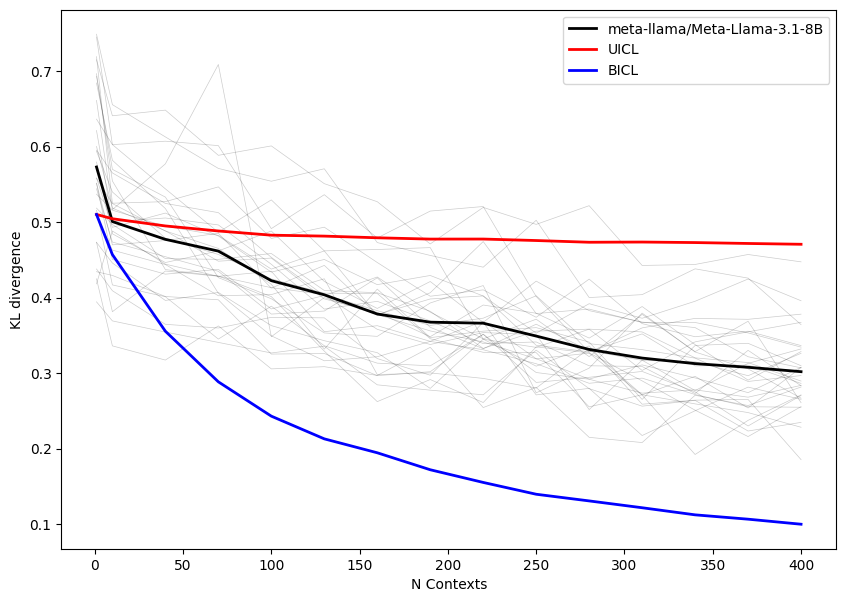

In [17]:
fig=plt.figure(figsize=(10,7))
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()
data["fig"]=fig

In [18]:
torch.save(data,save_path)

/tmp/ipykernel_823047/226546621.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load("./data/markov_mixture/llama/data_8B_v3.pt")


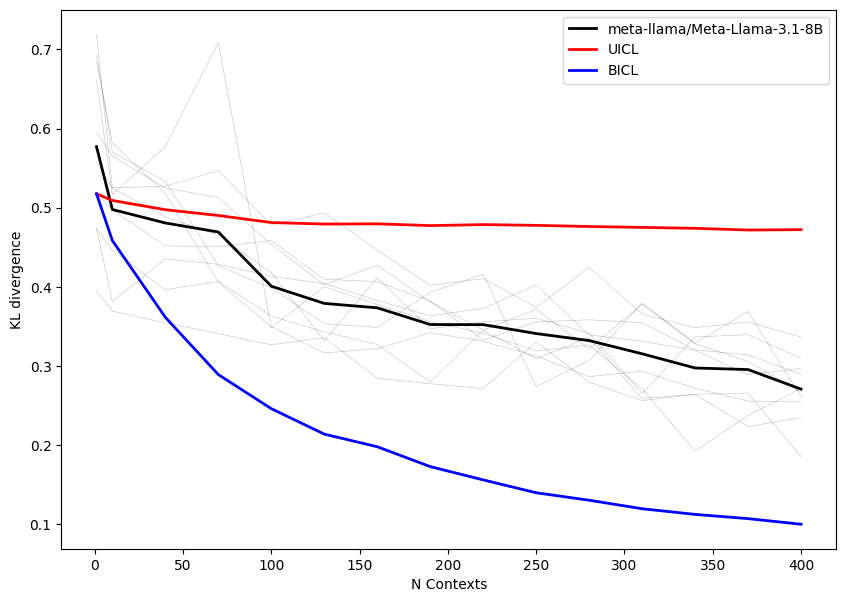

In [17]:
import torch
import matplotlib.pyplot as plt
data=torch.load("./data/markov_mixture/llama/data_8B_v3.pt")
n_contexts=data["n_contexts"]
kls=data["kls_model"]
kls_UICL=data["kls_UICL"]
kls_BICL=data["kls_BICL"]
model_name=data["model_name"]

fig=plt.figure(figsize=(10,7))
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()

/tmp/ipykernel_823047/444985463.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load(f"./data/markov_mixture/llama/{file_name}")


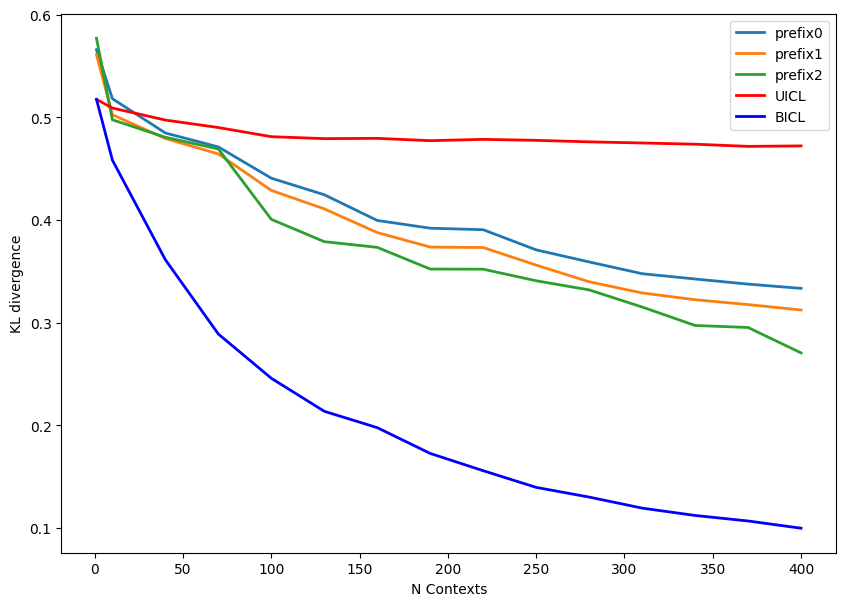

In [22]:
import torch
import matplotlib.pyplot as plt
file_names=["data_8B_v1.pt","data_8B_v2.pt","data_8B_v3.pt"]
klss={}
prefixes=[]
for i,file_name in enumerate(file_names):
    data=torch.load(f"./data/markov_mixture/llama/{file_name}")
    n_contexts=data["n_contexts"]
    kls=data["kls_model"]
    kls_UICL=data["kls_UICL"]
    kls_BICL=data["kls_BICL"]
    model_name=data["model_name"]
    prefix=data["prefix"]
    klss["prefix"+str(i)]=kls
    prefixes.append(prefix)
fig=plt.figure(figsize=(10,7))
for label,kls in klss.items():
    plt.plot(n_contexts,kls.mean(0),lw=2,label=label)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()

In [24]:
for i,prefix in enumerate(prefixes):
    print(i,prefix)

0 Continue the given sequence of digits between 0 and 9. The sequence is as follows:

1 Continue the given sequence of digits between 0 and 9. The sequence comes from a Markov process. The sequence is as follows:

2 Continue the given sequence of digits between 0 and 9. The sequence comes from a Markov process, so it only depends on the last state. The sequence is as follows:



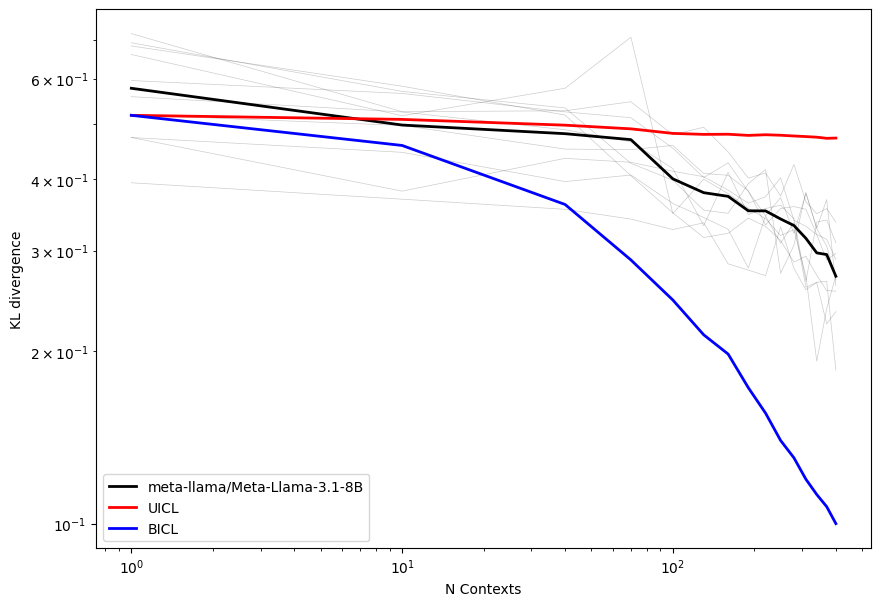

In [123]:
fig=plt.figure(figsize=(10,7))
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()
plt.yscale("log")
plt.xscale("log")

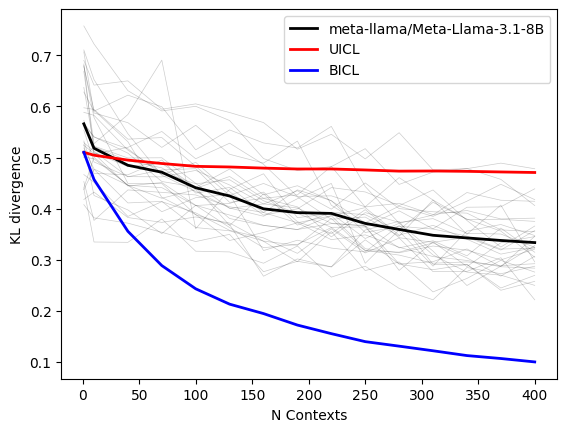

In [79]:
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()

In [32]:
positions=np.arange(i_sequence_start+1,len(token_ids),2).tolist()
len(positions)
relevant_logits_=relevant_logits[:,positions,:]
comma_probs=torch.nn.functional.softmax(relevant_logits_,dim=-1)[:,:,0]
states=data[1:]
state_probs=torch.nn.functional.softmax(relevant_logits_[:,1:],dim=-1)
comma_probs.shape,len(states),state_probs.shape

(torch.Size([511]), 511, torch.Size([511, 10]))

In [ ]:
transi

In [ ]:
state_probs

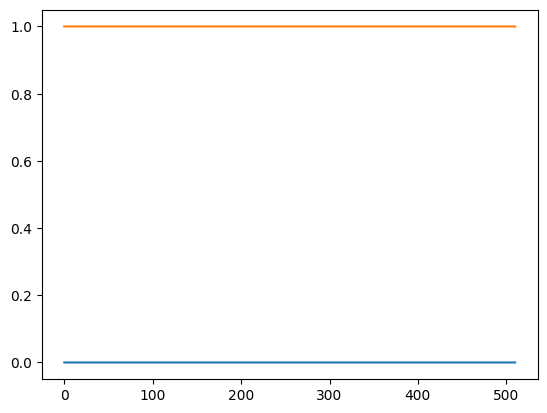

In [31]:
plt.plot(comma_probs)
plt.plot(state_probs.sum(-1))


In [ ]:
comma_probs=relevant_logits

In [12]:
relevant_logits[0]

tensor([[18.7500, -1.4297, -1.0078,  ..., -2.4219, -2.3281, -1.3906],
        [-1.9297, 16.5000, 17.3750,  ..., 15.6250, 15.4375, 16.7500],
        [22.7500,  0.2559, -0.5039,  ..., -1.0234, -1.2812, -1.1719],
        ...,
        [23.5000,  5.5938,  4.1250,  ...,  6.0625,  4.1875,  5.1250],
        [ 9.0625, 22.1250, 21.1250,  ..., 22.2500, 20.3750, 21.5000],
        [24.7500,  5.4688,  5.5000,  ...,  3.8438,  5.2500,  4.5938]])

In [112]:
logits.shape

LanguageModelProxy (proxy_call_4): 

In [99]:
import inspect
inspect.signature(llama.trace)

<Signature (*inputs: 'Any', trace: 'bool' = True, invoker_args: 'Dict[str, Any]' = None, backend: 'Union[Backend, str]' = None, remote: 'bool' = False, scan: 'bool' = False, **kwargs: 'Dict[str, Any]') -> 'Union[Tracer, Any]'>

In [92]:
comma_prob=torch.nn.functional.softmax(relevant_logits,dim=-1)
assert
comma_prob.shape

torch.Size([1, 117, 11])

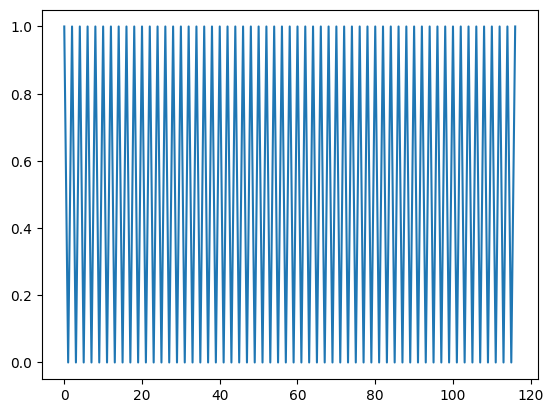

In [93]:
plt.plot(comma_prob[0,:,0])

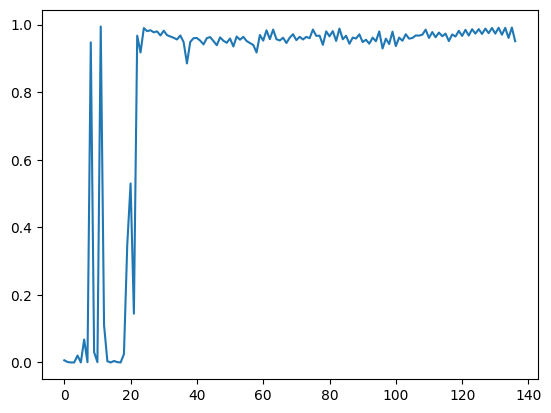

In [75]:
plt.plot(relevant_probs[0].sum(-1))

In [64]:
logits

tensor([[[-10.8750,   6.8125,   9.9375,   8.7500,   8.7500,   8.2500,   8.6250,
            7.8750,   7.8750,   7.5938,   7.4688],
         [  9.8125,  -5.8750,  -6.1250,  -5.7188,  -6.7188,  -5.9688,  -6.2812,
           -5.6875,  -6.0000,  -5.1875,  -5.3125],
         [-41.0000,   8.6250,  12.3125,  13.1250,  12.9375,  12.4375,  11.5000,
           10.6875,   9.6250,  10.7500,   9.1250],
         [ 14.2500, -10.3125, -11.5000, -11.6250,  -9.6250,  -9.5625, -11.0000,
          -10.0625, -10.1250,  -9.7500,  -9.8750],
         [-38.0000,   9.7500,  13.0000,  14.4375,  18.2500,  17.1250,  14.6875,
           14.2500,  12.8125,  12.5000,  11.6250],
         [ 18.0000,  -4.5625,  -5.4062,  -4.4375,  -3.8438,  -4.5312,  -5.1250,
           -3.0156,  -5.0625,  -4.9375,  -4.8438],
         [-27.3750,  10.5000,  15.0000,  18.3750,  19.0000,  17.2500,  16.2500,
           18.5000,  14.3125,  13.8125,  13.8750],
         [ 17.1250,  -7.6250,  -9.7500, -10.1875,  -9.5000,  -8.3125,  -7.6875,
   

In [52]:
logits.shape

torch.Size([1, 11, 128256])

In [ ]:
logits.shape